In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wavio
import IPython

In [2]:
def fxlms(un, dn, mu):
    """
    :param un: unknow signal(2-dimensional array). Rows are samples, columns are input arrays.
    :type  un: numpy.ndarray
    
    :param dn: expectation signal(1 dimensional array).
    :type  dn: numpy.ndarray
    
    :param M : array with initial weights (1 dimensional array) of filter size
    :type  M : numpy.ndarray
    
    :param mu: learning rate
    :type  mu: float
    
    :param n: length of filter(integer) - how many input is input array(row of input matrix)
    :type  n: int

    :return: yn, en, wn
    """
    # To ensure the length of un and dn is same
    ITER = min(len(un),len(dn)) 
    
    # Estimated Signal, FIR Product
    yn = np.zeros(ITER)
    
    # Error Signal, difference between estimation and expectation
    en = np.zeros(ITER)
    
    # Find the row of un
    _, n = np.shape(un)
    
    # FIR buffer
    wn = np.zeros(n)
    
    # History of all weights (2 dimensional array). Every row is set of the weights for given sample.
    wn_history = np.zeros((ITER, n))
    
    for k in range(ITER):
        wn_history[k,:] = wn
        yn[k] = np.dot(wn.T, un[k])
        en[k] = dn[k] - yn[k]
        dw = mu * en[k] * un[k]
        wn += dw
    return yn, en, wn_history

In [3]:
N = 500
un = np.random.normal(0, 1, (N, 4)) # input matrix - reference signal
vn = np.random.normal(0, 0.1, N) # noise - interference
dn = 2 * un[:,0] + 0.1*un[:,1] - 4*un[:,2] + 0.5*un[:,3] + vn # desired signal - reference signal with room convolution + interference
mu = 0.1

In [4]:
yn, en, wn = fxlms(un, dn, mu)

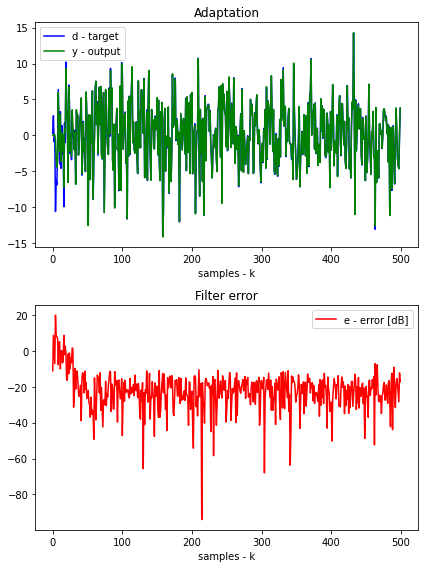

In [5]:
## show results
plt.figure(figsize=(6,8))

plt.subplot(211)
plt.title("Adaptation")
plt.xlabel("samples - k")
plt.plot(dn,"b", label="d - target")
plt.plot(yn,"g", label="y - output")
plt.legend()

plt.subplot(212)
plt.title("Filter error")
plt.xlabel("samples - k")
plt.plot(10*np.log10(en**2),"r", label="e - error [dB]")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
music_raw = wavio.read("music/music.wav")
room_drum_raw = wavio.read("music/drum_room.wav")
drum_raw = wavio.read("music/drum.wav")

music = music_raw.data[:, 0]
music = music.astype(np.float32, order='C') / 32767.0

room_drum = room_drum_raw.data[:, 0]
room_drum = room_drum.astype(np.float32, order='C') / 32767.0

drum = drum_raw.data[:, 0]
drum = drum.astype(np.float32, order='C') / 32767.0

In [7]:
length = min(len(drum), len(room_drum))
un = np.array((drum[:length], room_drum[:length])).T
dn = music
mu = 0.1

In [8]:
yn, en, wn = fxlms(un, dn, mu)

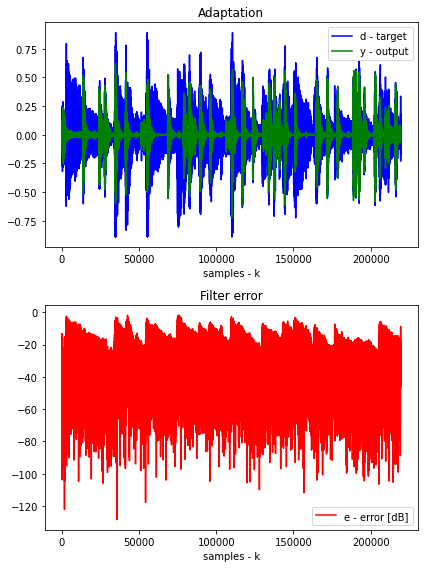

In [9]:
## show results
plt.figure(figsize=(6,8))

plt.subplot(211)
plt.title("Adaptation")
plt.xlabel("samples - k")
plt.plot(dn,"b", label="d - target")
plt.plot(yn,"g", label="y - output")
plt.legend()

plt.subplot(212)
plt.title("Filter error")
plt.xlabel("samples - k")
plt.plot(10*np.log10(en**2),"r", label="e - error [dB]")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
sr = 16000
wavio.write("result/en_fxlms.wav", en, sr, sampwidth=3)
wavio.write("result/yn_fxlms.wav", yn, sr, sampwidth=3)
IPython.display.display(IPython.display.Audio("result/en_fxlms.wav", rate=sr))
IPython.display.display(IPython.display.Audio("result/yn_fxlms.wav", rate=sr))
IPython.display.display(IPython.display.Audio("music/music.wav", rate=sr))

In [11]:
def fdaf(un, dn, M, mu=0.05, beta=0.9):
    H = np.zeros(M+1, dtype=np.complex)
    norm = np.full(M+1, 1e-8)
    
    window = np.hanning(M)
    x_last = np.zeros(M)
    
    num_block = len(un) // M
    e = np.zeros(num_block*M)
    
    for n in range(num_block):
        x_n = np.concatenate([x_last,un[n*M:(n+1)*M]])
        d_n = dn[n*M:(n+1)*M]
        x_last = un[n*M:(n+1)*M]

        X_n = np.fft.rfft(x_n)
        y_n = np.fft.irfft(H*X_n)[M:]
        e_n = d_n-y_n
        e[n*M:(n+1)*M] = e_n

        e_fft = np.concatenate([np.zeros(M),e_n*window])
        E_n = np.fft.rfft(e_fft)

        norm = beta*norm + (1-beta)*np.abs(X_n)**2
        G = mu*E_n/norm
        H = H + X_n.conj()*G

        h = np.fft.irfft(H)
        h[M:] = 0
        H = np.fft.rfft(h)
        
    return e, h

In [12]:
un = drum 
dn = room_drum
mu = 0.2
M = 8192
en, hn = fdaf(un, dn, M, mu, 0.9)
hn = hn[0:M]

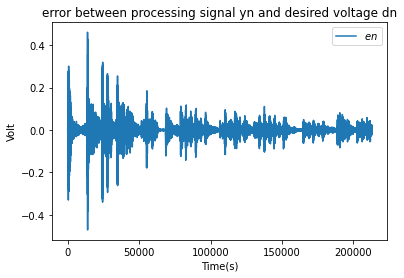

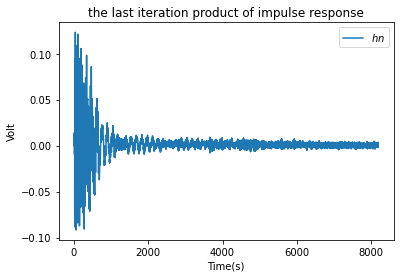

In [13]:
plt.figure(1)
plt.plot(en,label="$en$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.figure(2)
plt.plot(hn,label="$hn$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("the last iteration product of impulse response")
plt.legend()

plt.show()

In [14]:
drum_convolution = np.convolve(drum, hn)

un = np.array((drum[:length], drum_convolution[:length], room_drum[:length])).T
dn = music
mu = 0.25

yn, en, wn = fxlms(un, dn, mu)

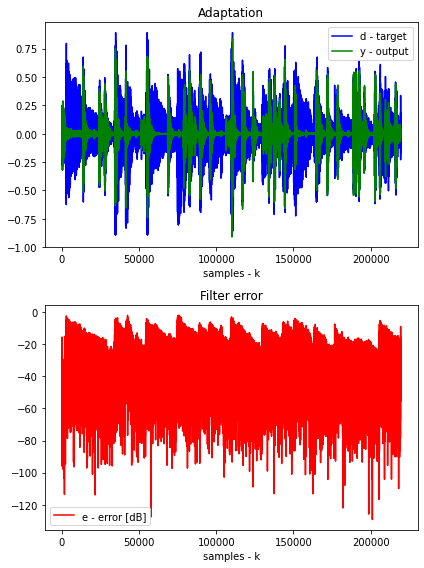

In [15]:
## show results
plt.figure(figsize=(6,8))

plt.subplot(211)
plt.title("Adaptation")
plt.xlabel("samples - k")
plt.plot(dn,"b", label="d - target")
plt.plot(yn,"g", label="y - output")
plt.legend()

plt.subplot(212)
plt.title("Filter error")
plt.xlabel("samples - k")
plt.plot(10*np.log10(en**2),"r", label="e - error [dB]")
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
sr = 16000
wavio.write("result/en_fxlms_fdaf.wav", en, sr, sampwidth=3)
wavio.write("result/yn_fxlms_fdaf.wav", yn, sr, sampwidth=3)
IPython.display.display(IPython.display.Audio("result/en_fxlms_fdaf.wav", rate=sr))
IPython.display.display(IPython.display.Audio("result/yn_fxlms_fdaf.wav", rate=sr))
IPython.display.display(IPython.display.Audio("music/music.wav", rate=sr))